##Import Libraries and Load Data

In this section, we import the necessary libraries and load the MNIST dataset, which is a collection of handwritten digit images.

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import fetch_openml

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


##Data Preprocessing and Splitting

In this section, we preprocess the dataset. We normalize the input images and encode the labels into one-hot format. Then, we split the dataset into training, validation, and test sets.

In [19]:
# Preprocessing
X = X / 255.0
encoder = LabelBinarizer()
y = encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


##Convert Data to NumPy Arrays

In this section, we convert the data (X_train, X_val, and X_test) from pandas DataFrames to NumPy arrays, which are more suitable for numerical operations.

In [20]:
# Convert data to NumPy arrays
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()


##Define the Echo State Network (ESN) Class

Here, we define the class EchoStateNetwork, which represents an Echo State Network. This class will be used for training and making predictions using the ESN model.

In [21]:
# Define the Echo State Network (ESN)
class EchoStateNetwork:
    def __init__(self, input_size, reservoir_size, spectral_radius):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius

        # Initialize the reservoir weights
        np.random.seed(42)
        self.W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        self.W *= 0.9 / np.max(np.abs(np.linalg.eigvals(self.W)))  # Scale the weights by spectral radius

        # Initialize the input weights and bias
        self.W_in = np.random.rand(reservoir_size, input_size) - 0.5
        self.b = np.random.rand(reservoir_size, 1) - 0.5

    def _compute_reservoir_states(self, X):
        T = X.shape[0]
        X = X.T

        # Initialize the reservoir states
        X_reservoir = np.zeros((self.reservoir_size, T))

        # Compute the reservoir states
        for t in range(1, T):
            u = X[:, t].reshape(-1, 1)
            x_prev = X_reservoir[:, t-1].reshape(-1, 1)
            x = np.tanh(self.W_in @ u + self.W @ x_prev + self.b)
            X_reservoir[:, t] = x.flatten()

        return X_reservoir

    def train(self, X, y):
        # Compute the reservoir states
        X_reservoir = self._compute_reservoir_states(X)

        # Ridge regression training
        clf = LinearRegression()
        clf.fit(X_reservoir.T, y)

        self.clf = clf

    def predict(self, X):
        # Compute the reservoir states
        X_reservoir = self._compute_reservoir_states(X)

        # Perform predictions using the trained regressor
        y_pred = self.clf.predict(X_reservoir.T)

        return y_pred

##Create and Train the Echo State Network (ESN)

In this section, we set the hyperparameters for the ESN, create an instance of the EchoStateNetwork class, and train the ESN model using the training data.

In [22]:
# Set ESN hyperparameters
input_size = X_train.shape[1]
reservoir_size = 1000
spectral_radius = 0.9

# Create and train the Echo State Network (ESN)
esn = EchoStateNetwork(input_size, reservoir_size, spectral_radius)
esn.train(X_train, y_train)


##Validate the Echo State Network (ESN)

In this section, we validate the performance of the trained ESN on the validation set and calculate the validation accuracy.

In [23]:
# Make predictions on the validation set
y_val_pred = esn.predict(X_val)

# Convert predictions to one-hot encoding
y_val_pred_onehot = np.argmax(y_val_pred, axis=1)
y_val_onehot = np.argmax(y_val, axis=1)

# Calculate and print the validation accuracy
val_accuracy = accuracy_score(y_val_onehot, y_val_pred_onehot)
print("ESN Validation Accuracy:", val_accuracy)


ESN Validation Accuracy: 0.9209821428571429


##Train Linear Regression Model

This section trains a linear regression model on the flattened input images.

In [24]:
# Train linear regression on flattened input images
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)


LinearRegression()

##Validate the Linear Regression Model

Here, we validate the performance of the linear regression model on the validation set and calculate the validation accuracy.

In [25]:
# Make predictions on the validation set using linear regression
y_val_pred_linear = linear_reg.predict(X_val)

# Convert predictions to one-hot encoding
y_val_pred_linear_onehot = np.argmax(y_val_pred_linear, axis=1)

# Calculate and print the validation accuracy for linear regression
val_accuracy_linear = accuracy_score(y_val_onehot, y_val_pred_linear_onehot)
print("Linear Regression Validation Accuracy:", val_accuracy_linear)


Linear Regression Validation Accuracy: 0.8509821428571429


##Test the Models and Calculate Test Accuracies

This section tests both the ESN and linear regression models on the test set and calculates their test accuracies.

In [26]:
# Make predictions on the test set using ESN
y_test_pred = esn.predict(X_test)

# Convert predictions to one-hot encoding
y_test_pred_onehot = np.argmax(y_test_pred, axis=1)
y_test_onehot = np.argmax(y_test, axis=1)

# Calculate and print the test accuracy for ESN
test_accuracy = accuracy_score(y_test_onehot, y_test_pred_onehot)
print("ESN Test Accuracy:", test_accuracy)

# Make predictions on the test set using linear regression
y_test_pred_linear = linear_reg.predict(X_test)

# Convert predictions to one-hot encoding
y_test_pred_linear_onehot = np.argmax(y_test_pred_linear, axis=1)

# Calculate and print the test accuracy for linear regression
test_accuracy_linear = accuracy_score(y_test_onehot, y_test_pred_linear_onehot)
print("Linear Regression Test Accuracy:", test_accuracy_linear)


ESN Test Accuracy: 0.9195714285714286
Linear Regression Test Accuracy: 0.8542142857142857


In [28]:
## Define a function to plot a confusion matrix with numbers
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display the numbers within the confusion matrix regions with colors
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##Confusion Matrix and Classification Reports

In this section, we generate confusion matrices and classification reports for both the ESN and linear regression models and visualize the confusion matrices.

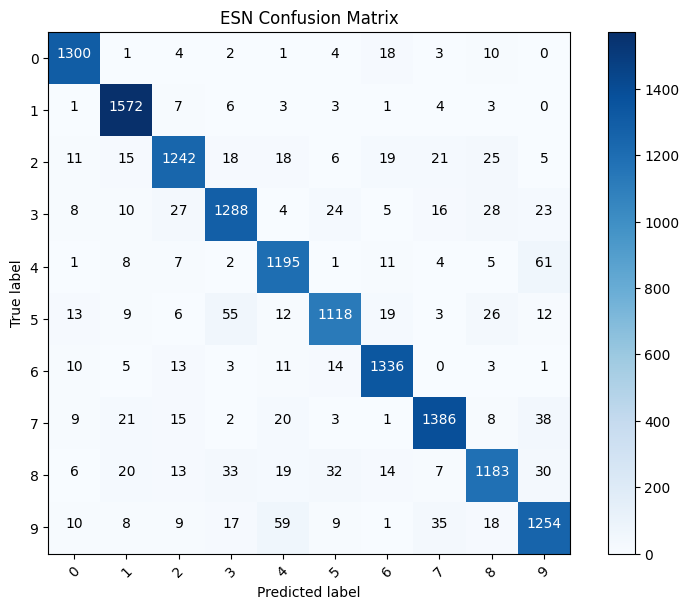

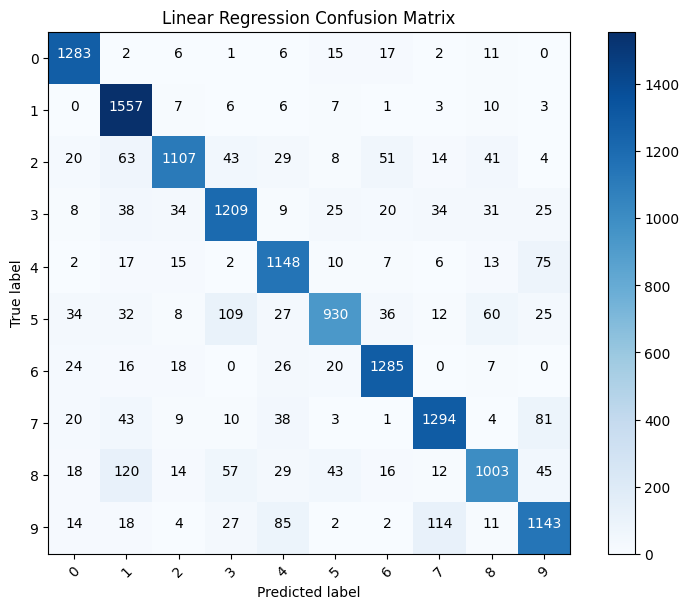

ESN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1343
           1       0.94      0.98      0.96      1600
           2       0.92      0.90      0.91      1380
           3       0.90      0.90      0.90      1433
           4       0.89      0.92      0.91      1295
           5       0.92      0.88      0.90      1273
           6       0.94      0.96      0.95      1396
           7       0.94      0.92      0.93      1503
           8       0.90      0.87      0.89      1357
           9       0.88      0.88      0.88      1420

    accuracy                           0.92     14000
   macro avg       0.92      0.92      0.92     14000
weighted avg       0.92      0.92      0.92     14000

Linear Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1343
           1       0.82      0.97      0.89      1600
          

In [30]:
# Define class labels (replace with your own if needed)
class_labels = [str(i) for i in range(10)]
# Generate confusion matrices and classification reports for both models
cm_esn = confusion_matrix(y_test_onehot, y_test_pred_onehot)
report_esn = classification_report(y_test_onehot, y_test_pred_onehot)

cm_linear = confusion_matrix(y_test_onehot, y_test_pred_linear_onehot)
report_linear = classification_report(y_test_onehot, y_test_pred_linear_onehot)

# Plot confusion matrices
plot_confusion_matrix(cm_esn, classes=class_labels, title='ESN Confusion Matrix')
plt.show()

plot_confusion_matrix(cm_linear, classes=class_labels, title='Linear Regression Confusion Matrix')
plt.show()

# Print classification reports
print("ESN Classification Report:")
print(report_esn)

print("Linear Regression Classification Report:")
print(report_linear)

# Echo State Network (ESN) for Time Series Classification on ECG5000

This code implements an Echo State Network (ESN) for time series classification using Python. ESNs are a type of recurrent neural network suitable for a wide range of applications, including time series prediction and classification.

## ESN Class

The `EchoStateNetworkImproved` class is defined to create an ESN with various hyperparameters and training methods. Key components of this class include:

- Reservoir size
- Spectral radius
- Connectivity
- Input scaling
- Activation function
- Weight initialization methods
- Training method using ridge regression

## Data Preparation

The code loads the ECG5000 dataset from OpenML, ensures class balance, and splits it into training and testing sets.

## Weight Initialization Methods

A list of weight initialization methods is defined, and the code iterates through these methods to create and train ESNs with different weight initializations.

- Sparsity
- Identity
- Diagonal
- Tridiagonal
- Upper triangular
- Lower triangular
- Leading diagonal
- Diagonal + Leading
- Trailing diagonal

## Training and Evaluation

For each weight initialization method, the ESN is trained on the training data, and its performance is evaluated on the testing data. Evaluation metrics include accuracy and a detailed classification report, including precision, recall, and F1-score.

## Confusion Matrix

The code also generates and displays a confusion matrix for each weight initialization method to visualize the model's performance.

## Results

The results of each weight initialization method, including accuracy and classification reports, are stored in a DataFrame and printed to the console. Additionally, the results are saved to a CSV file named `esn_results.csv`.

This structured and documented code provides a comprehensive overview of ESN training and evaluation for time series classification with different weight initialization methods.



Let's first import the required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import fetch_openml
import pandas as pd
import seaborn as sns

As we have already imported the required libraries, now we can load the ECG5000 dataset from openML

In [ ]:
# Load the ECG5000 dataset from OpenML
dataset = fetch_openml(data_id=44793)
X, y = dataset.data, dataset.target
print(X.shape)
print(y.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(4998, 140)
(4998,)


The data is not balanced for each of the classes so we need to balance it first

In [ ]:
# Ensure balanced instances for each class
unique_classes = np.unique(y)
min_class_count = min([np.sum(y == c) for c in unique_classes])
X_balanced = np.concatenate([X[y == c][:min_class_count] for c in unique_classes])
y_balanced = np.concatenate([y[y == c][:min_class_count] for c in unique_classes])
print(X_balanced.shape)
print(y_balanced.shape)

(4158, 140)
(4158,)


As the dataset is now balanced, we can now split the dataset into train and test set

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3326, 140) (832, 140) (3326,) (832,)


Following code shows the weight matrix for each of the choices

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


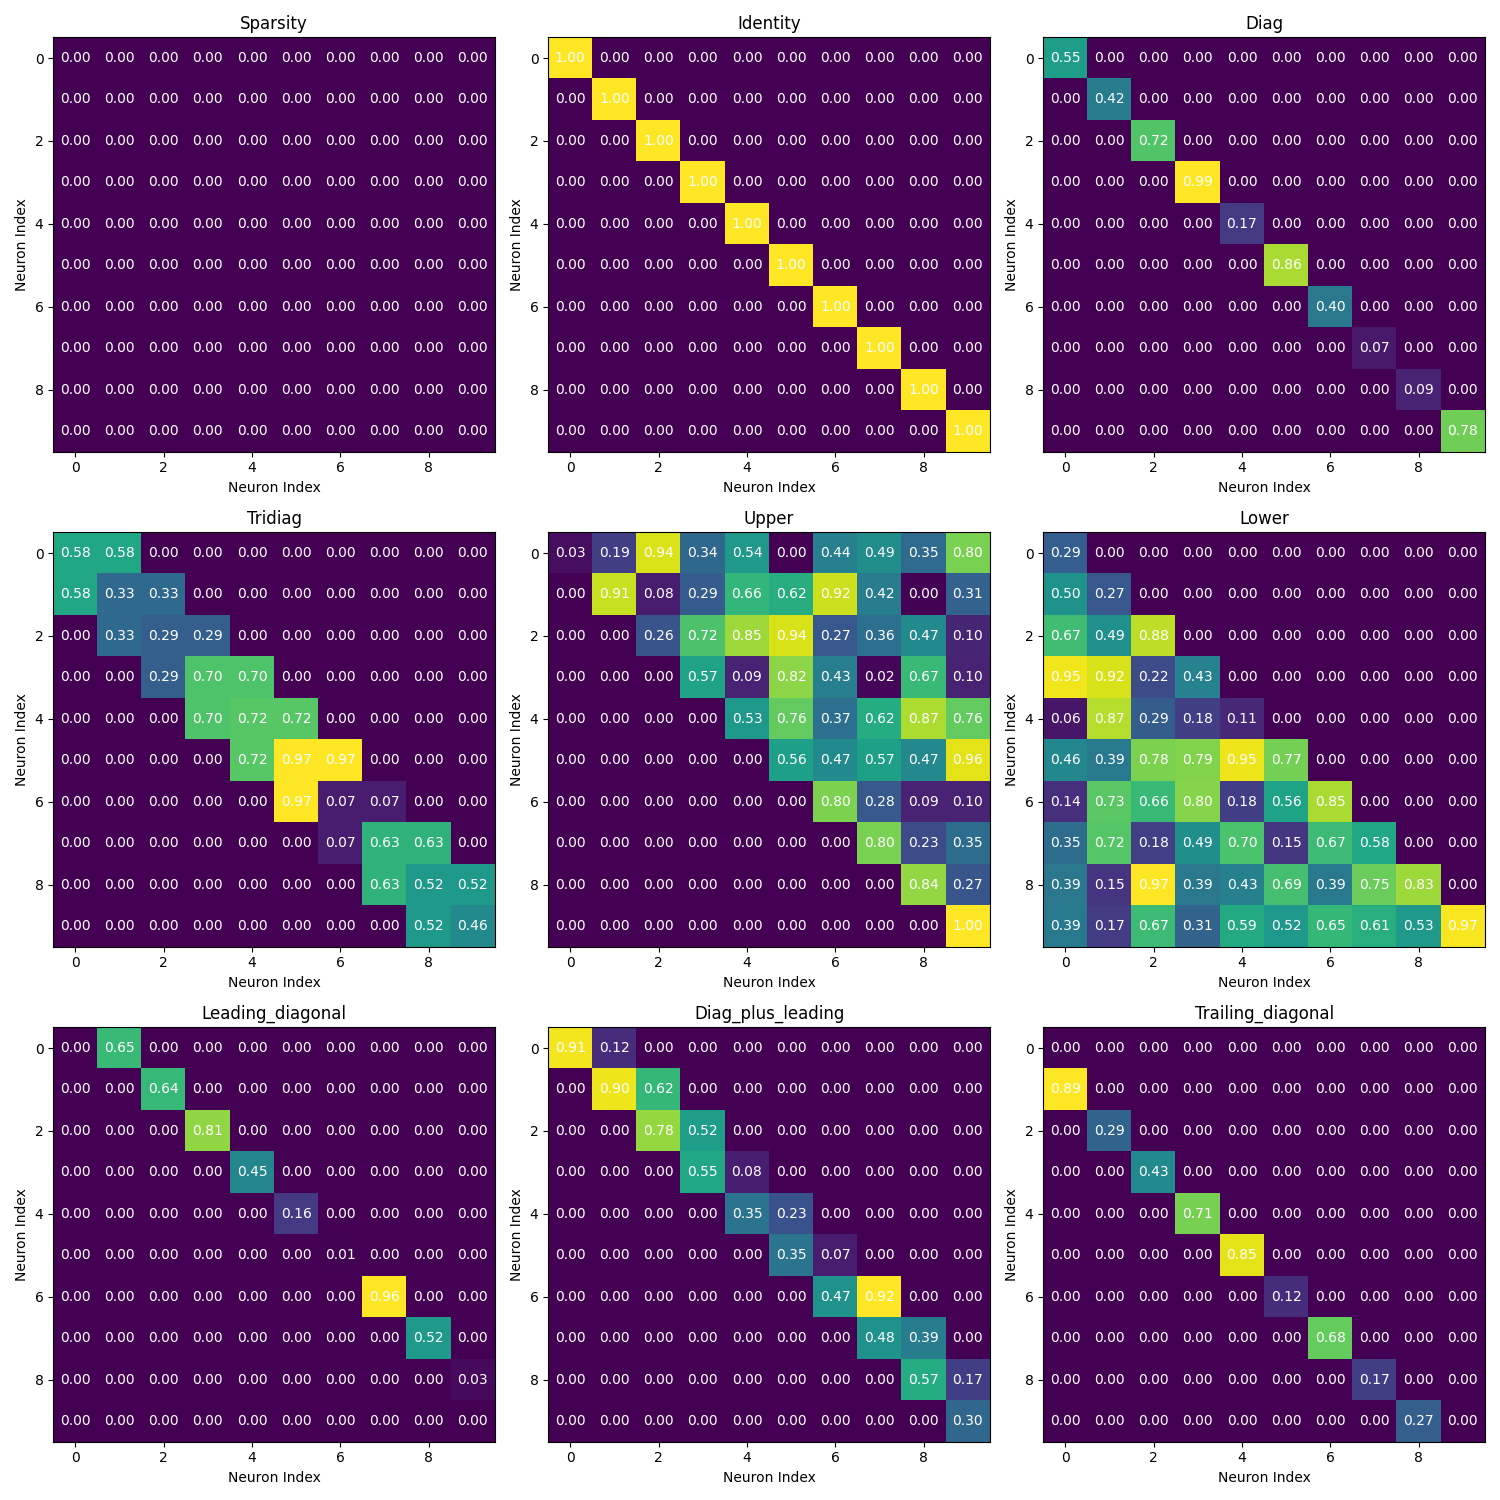

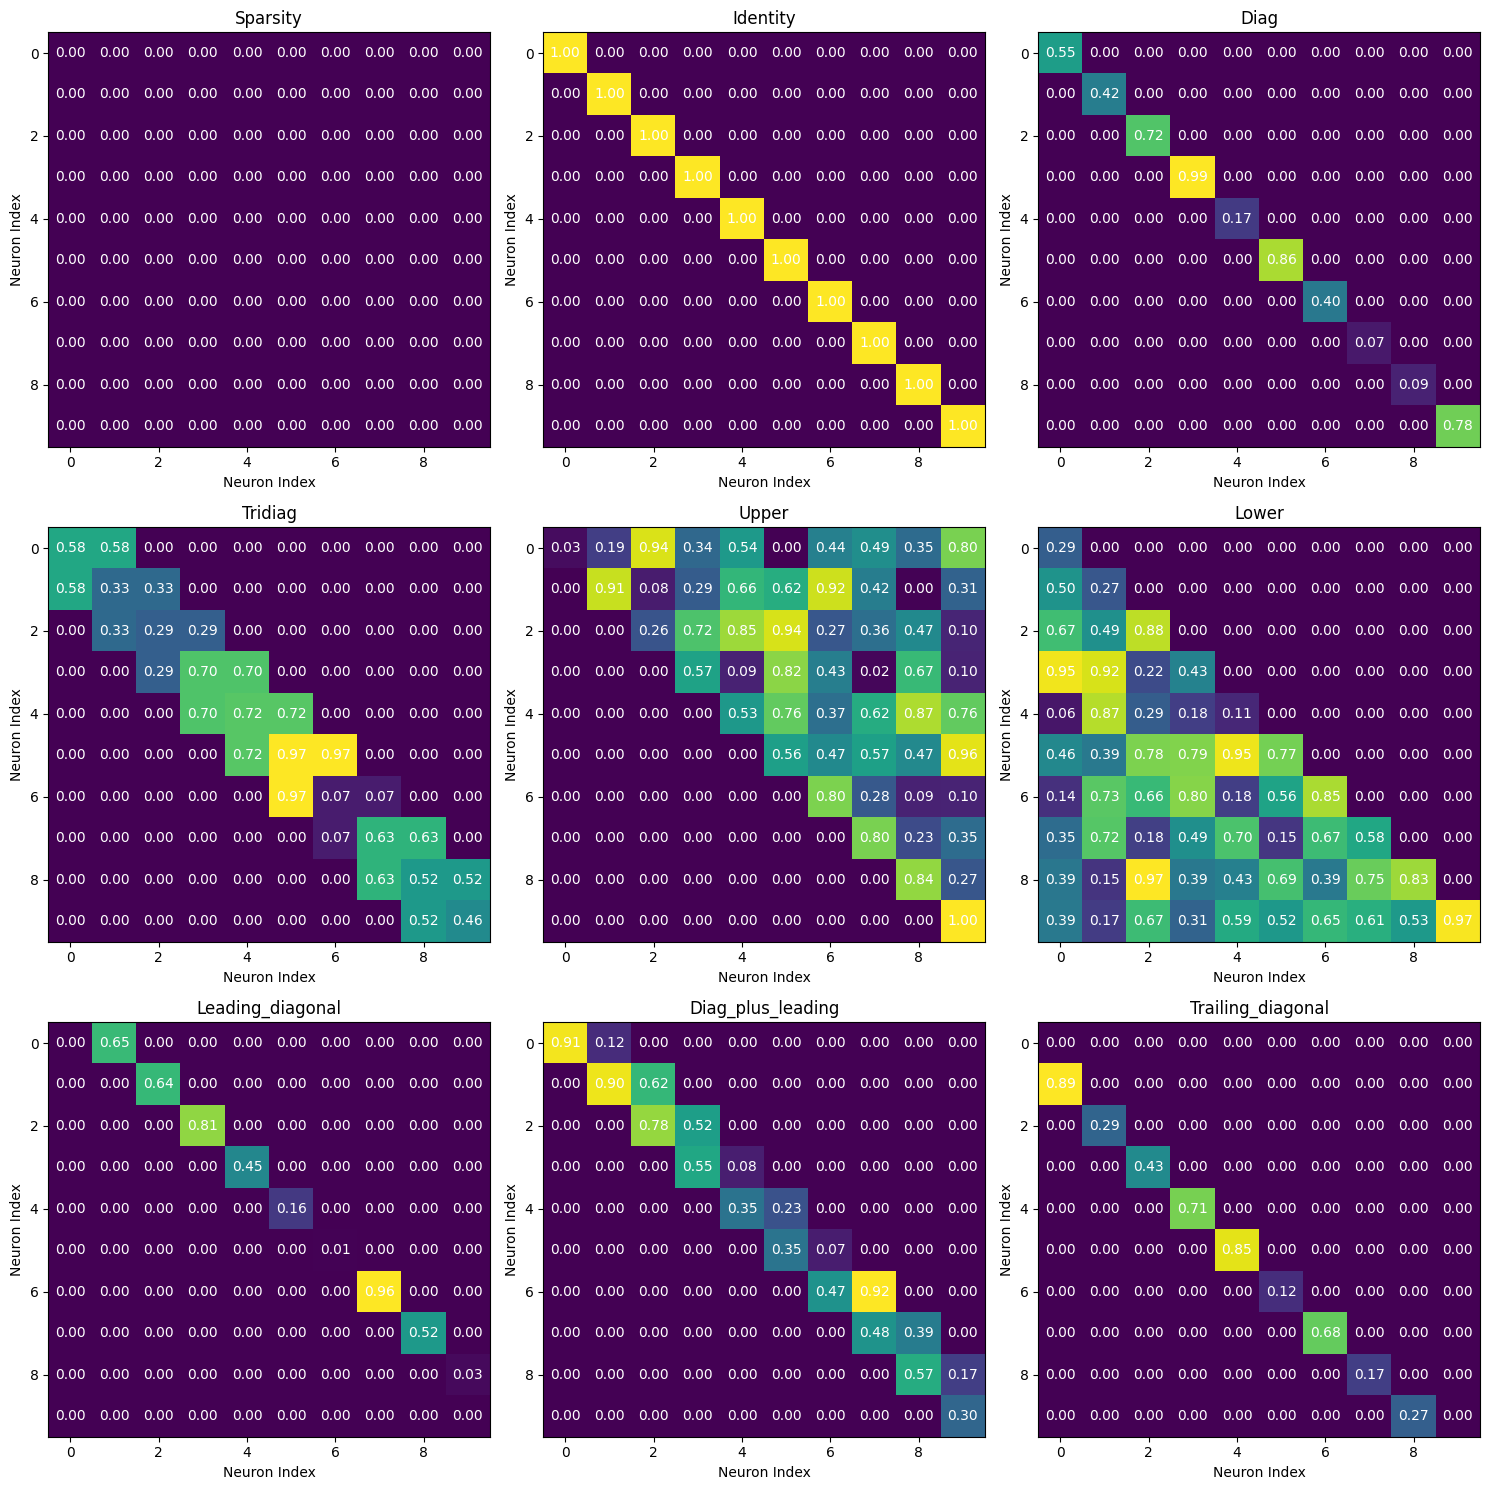

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml

class EchoStateNetwork:
    def __init__(self, reservoir_size=500, spectral_radius=0.9, weight_init='sparsity', input_scaling=0.2):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.weight_init = weight_init
        self.input_scaling = input_scaling

        self.W_in = None
        self.W_res = None
        self.W_out = None
        self.leak_rate = 0.3  # You can adjust this if needed
        self.alpha = 1.0  # Ridge regression regularization parameter
    def _activation(self, x):
        return np.tanh(x)


    def predict(self, X):
        X = StandardScaler().fit_transform(X)

        X_reservoir = np.zeros((self.reservoir_size, X.shape[0]))

        for t in range(X.shape[0]):
            u = X[t]
            X_reservoir[:, t] = self._activation(np.dot(self.W_in, u) + np.dot(self.W_res, X_reservoir[:, t - 1]))

        y_pred = np.dot(X_reservoir.T, self.W_out)
        return y_pred

    def predict_classes(self, X, threshold=0.5):
        y_pred = self.predict(X)
        y_pred_classes = (y_pred > threshold).astype(int)
        return y_pred_classes

    def create_combined_connectivity(self):
        connectivity = np.zeros((self.reservoir_size, self.reservoir_size))
        np.fill_diagonal(connectivity, 1.0)

        for i in range(1, self.reservoir_size):
            connectivity[i, i - 1] = 1.0

        for i in range(self.reservoir_size - 1):
            connectivity[i, i + 1] = 1.0

        mask = np.random.rand(self.reservoir_size, self.reservoir_size) > self.connectivity
        connectivity[mask] = 0.0

        return connectivity

    def fit(self, X, y, washout=100):
        # Normalize the input features
        X = StandardScaler().fit_transform(X)

        # Encode class labels
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)

        if self.weight_init == 'sparsity':
            self.W_res = np.random.rand(self.reservoir_size, self.reservoir_size)
            self.W_res[self.W_res > self.spectral_radius] = 0
        elif self.weight_init == 'identity':
            self.W_res = np.identity(self.reservoir_size)
        elif self.weight_init == 'diag':
            self.W_res = np.diag(np.random.rand(self.reservoir_size))
        elif self.weight_init == 'tridiag':
            upper_diag = np.random.rand(self.reservoir_size)
            self.W_res = np.diag(upper_diag) + np.diag(upper_diag[:-1], 1) + np.diag(upper_diag[:-1], -1)
        elif self.weight_init == 'leading_diagonal':
            lower_diag = np.random.rand(self.reservoir_size-1)
            self.W_res = np.diag(lower_diag, k=1)
        elif self.weight_init == 'diag_plus_leading':
            diag = np.random.rand(self.reservoir_size - 1)
            self.W_res = np.diag(np.random.rand(self.reservoir_size)) + np.diag(diag, k=1)
        elif self.weight_init == 'trailing_diagonal':
            diag = np.random.rand(self.reservoir_size - 1)
            self.W_res =  np.diag(diag, k=-1)
        elif self.weight_init== 'upper':
            self.W_res = np.triu(np.random.rand(self.reservoir_size, self.reservoir_size))
        elif self.weight_init == 'lower':
            self.W_res = np.tril(np.random.rand(self.reservoir_size, self.reservoir_size))

        #self.W_res[self.W_res > self.spectral_radius] = 0  # Sparsity
        # Spectral radius scaling
        spectral_radius = max(np.abs(np.linalg.eigvals(self.W_res)))
        #self.W_res /= spectral_radius * self.spectral_radius

        # Generate the input weights
        self.W_in = (2.0 * np.random.rand(self.reservoir_size, X.shape[1]) - 1.0) * self.input_scaling

        # Initialize the internal states
        X_reservoir = np.zeros((self.reservoir_size, X.shape[0]))

        for t in range(X.shape[0]):
            u = X[t]
            X_reservoir[:, t] = self._activation(np.dot(self.W_in, u) + np.dot(self.W_res, X_reservoir[:, t - 1]))

        # Washout period
        X_reservoir = X_reservoir[:, washout:]

        # Ridge regression training
        I = np.identity(self.reservoir_size)
        A = np.dot(X_reservoir, X_reservoir.T) + self.alpha * I
        B = np.dot(X_reservoir, y_encoded[washout:])
        self.W_out = np.dot(np.linalg.inv(A), B)

        return self.W_res  # Return the connectivity matrix

# Load the ECG5000 dataset from OpenML
dataset = fetch_openml(data_id=44793)
X, y = dataset.data, dataset.target

# Ensure balanced instances for each class
unique_classes = np.unique(y)
min_class_count = min([np.sum(y == c) for c in unique_classes])
X_balanced = np.concatenate([X[y == c][:min_class_count] for c in unique_classes])
y_balanced = np.concatenate([y[y == c][:min_class_count] for c in unique_classes])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Define connectivity options
connectivity_options =['sparsity', 'identity', 'diag', 'tridiag', 'upper', 'lower','leading_diagonal','diag_plus_leading','trailing_diagonal']

# Create a subplot grid to display heatmaps
num_rows = 3
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Loop through each connectivity option and generate heatmaps
for i, option in enumerate(connectivity_options):
    # Create an instance of the Echo State Network with the chosen connectivity option
    esn = EchoStateNetwork(reservoir_size=10, spectral_radius=0.01, weight_init=option, input_scaling=0.2)

    # Fit the ESN to the training data and get the connectivity matrix
    connectivity_matrix = esn.fit(X_train, y_train)

    # Plot the heatmap in the current subplot
    row = i // num_cols
    col = i % num_cols
    im = axs[row, col].imshow(connectivity_matrix, cmap='viridis', aspect='auto')
    axs[row, col].set_title(option.capitalize())
    axs[row, col].set_xlabel('Neuron Index')
    axs[row, col].set_ylabel('Neuron Index')

    # Annotate each cell with its value
    for j in range(connectivity_matrix.shape[0]):
        for k in range(connectivity_matrix.shape[1]):
            axs[row, col].text(k, j, f'{connectivity_matrix[j, k]:.2f}', ha='center', va='center', color='white')

# Adjust layout and display
plt.tight_layout()

# Save the current figure as an image (e.g., in PNG format)
output_image_filename = 'connectivity_matrices.png'
plt.savefig(output_image_filename)

# Display the saved image file
from IPython.display import Image
Image(filename=output_image_filename)


Let's define Echo State Network

In [ ]:
class EchoStateNetworkImproved:
    def __init__(self, reservoir_size=500, spectral_radius=0.9, connectivity=0.1, input_scaling=0.2):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scaling = input_scaling

        self.W_in = None
        self.W_res = None
        self.W_out = None
        self.leak_rate = 0.3
        self.alpha = 1.0

    def _activation(self, x):
        return np.tanh(x)

    def fit(self, X, y, washout=100, weight_init='sparsity'):
        X = StandardScaler().fit_transform(X)
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)


        if weight_init == 'sparsity':
            self.W_res = np.random.rand(self.reservoir_size, self.reservoir_size)
            self.W_res[self.W_res > self.spectral_radius] = 0

            # Calculate the spectral radius of the reservoir weight matrix
            spectral_radius = np.max(np.abs(np.linalg.eigvals(self.W_res)))

            # Add a small constant to the spectral radius if it's zero
            if spectral_radius == 0:
                spectral_radius = 1e-6  # You can adjust the constant as needed

            # Normalize the weight matrix to achieve the desired spectral radius
            self.W_res /= spectral_radius
        elif weight_init == 'identity':
            self.W_res = np.identity(self.reservoir_size)
        elif weight_init == 'diag':
            self.W_res = np.diag(np.random.rand(self.reservoir_size))
        elif weight_init == 'tridiag':
            upper_diag = np.random.rand(self.reservoir_size)
            self.W_res = np.diag(upper_diag) + np.diag(upper_diag[:-1], 1) + np.diag(upper_diag[:-1], -1)
        elif weight_init == 'leading_diagonal':
            lower_diag = np.random.rand(self.reservoir_size-1)
            self.W_res = np.diag(lower_diag, k=1)
        elif weight_init == 'diag_plus_leading':
            diag = np.random.rand(self.reservoir_size - 1)
            self.W_res = np.diag(np.random.rand(self.reservoir_size)) + np.diag(diag, k=1)
        elif weight_init == 'trailing_diagonal':
            diag = np.random.rand(self.reservoir_size - 1)
            self.W_res =  np.diag(diag, k=-1)
        elif weight_init== 'upper':
            self.W_res = np.triu(np.random.rand(self.reservoir_size, self.reservoir_size))
        elif weight_init == 'lower':
            self.W_res = np.tril(np.random.rand(self.reservoir_size, self.reservoir_size))

        # Ensure that self.W_res is properly initialized
        if self.W_res is None:
            raise ValueError("Weight initialization method not recognized.")

        # Ensure the spectral_radius is not zero to avoid division by zero
        if self.spectral_radius == 0:
            self.spectral_radius = 1

        self.W_res /= self.spectral_radius * self.spectral_radius

        self.W_in = (2.0 * np.random.rand(self.reservoir_size, X.shape[1]) - 1.0) * self.input_scaling

        X_reservoir = np.zeros((self.reservoir_size, X.shape[0]))

        for t in range(X.shape[0]):
            u = X[t]
            X_reservoir[:, t] = self._activation(np.dot(self.W_in, u) + np.dot(self.W_res, X_reservoir[:, t - 1]))

        X_reservoir = X_reservoir[:, washout:]

        I = np.identity(self.reservoir_size)
        A = np.dot(X_reservoir, X_reservoir.T) + self.alpha * I
        B = np.dot(X_reservoir, y_encoded[washout:])
        self.W_out = np.dot(np.linalg.inv(A), B)

    def predict(self, X):
        X = StandardScaler().fit_transform(X)
        X_reservoir = np.zeros((self.reservoir_size, X.shape[0]))

        for t in range(X.shape[0]):
            u = X[t]
            X_reservoir[:, t] = self._activation(np.dot(self.W_in, u) + np.dot(self.W_res, X_reservoir[:, t - 1]))

        y_pred = np.dot(X_reservoir.T, self.W_out)
        return y_pred

    def predict_classes(self, X, threshold=0.5):
        y_pred = self.predict(X)
        y_pred_classes = (y_pred > threshold).astype(int)
        return y_pred_classes


Let's test the architectures now

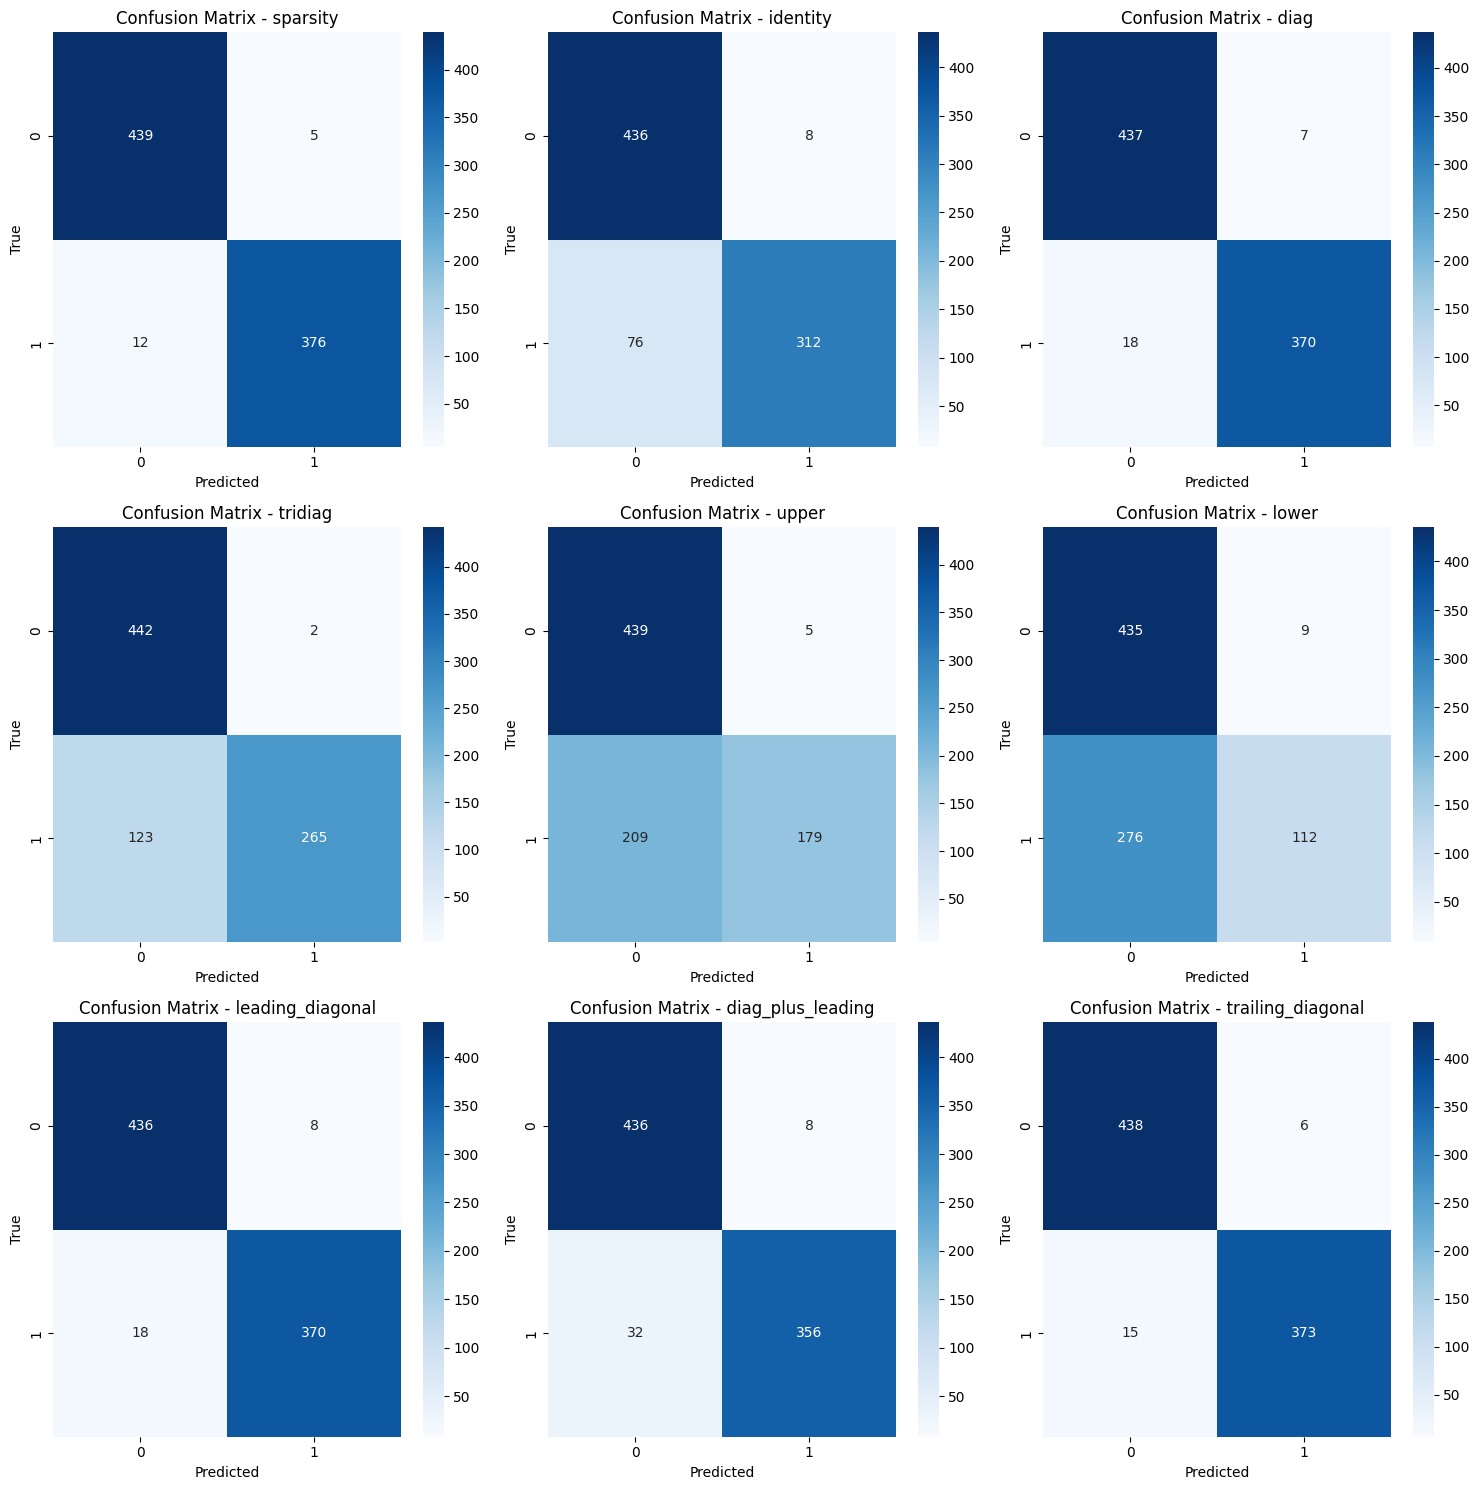

  Weight Init Method  Accuracy  \
0           sparsity  0.979567   
1           identity  0.899038   
2               diag  0.969952   
3            tridiag  0.849760   
4              upper  0.742788   
5              lower  0.657452   
6   leading_diagonal  0.968750   
7  diag_plus_leading  0.951923   
8  trailing_diagonal  0.974760   

                               Classification Report  
0  {'0': {'precision': 0.9733924611973392, 'recal...  
1  {'0': {'precision': 0.8515625, 'recall': 0.981...  
2  {'0': {'precision': 0.9604395604395605, 'recal...  
3  {'0': {'precision': 0.7823008849557522, 'recal...  
4  {'0': {'precision': 0.6774691358024691, 'recal...  
5  {'0': {'precision': 0.6118143459915611, 'recal...  
6  {'0': {'precision': 0.960352422907489, 'recall...  
7  {'0': {'precision': 0.9316239316239316, 'recal...  
8  {'0': {'precision': 0.9668874172185431, 'recal...  
{'sparsity': [], 'identity': [], 'diag': [], 'tridiag': [], 'upper': [], 'lower': [], 'leading_diagonal': [],

In [ ]:
# Define a list of weight initialization methods to test
weight_init_methods = ['sparsity', 'identity', 'diag', 'tridiag', 'upper', 'lower', 'leading_diagonal', 'diag_plus_leading', 'trailing_diagonal']

# Create dataframes to store results
results_df = pd.DataFrame(columns=['Weight Init Method', 'Accuracy', 'Classification Report'])

# Create dictionaries to store results
accuracy_results = {method: [] for method in weight_init_methods}

# Create a grid for confusion matrices
grid_rows = 3
grid_cols = 3
plt.figure(figsize=(15, 15))

# Create an empty list to store individual result DataFrames
results_dfs = []
for i, weight_init_method in enumerate(weight_init_methods):
    # Create a subplot for each confusion matrix
    plt.subplot(grid_rows, grid_cols, i + 1)

    esn = EchoStateNetworkImproved(reservoir_size=700, spectral_radius=0.9, connectivity=0.1, input_scaling=0.2)
    esn.fit(X_train, y_train, weight_init=weight_init_method)

    y_pred_classes = esn.predict_classes(X_test, threshold=0.5)

    cm = confusion_matrix(y_test, y_pred_classes, labels=unique_classes)

    # # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
    plt.title(f'Confusion Matrix - {weight_init_method}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Display the classification report
    classification_rep = classification_report(y_test, y_pred_classes, labels=unique_classes, target_names=[str(cls) for cls in unique_classes], output_dict=True)

    # Create a DataFrame for the results of this method
    results_df = pd.DataFrame({
        'Weight Init Method': [weight_init_method],
        'Accuracy': [accuracy_score(y_test, y_pred_classes)],
        'Classification Report': [classification_rep]
    })

    # Append the DataFrame to the list of results
    results_dfs.append(results_df)

# Concatenate all individual result DataFrames into one
results_df = pd.concat(results_dfs, ignore_index=True)

plt.tight_layout()
plt.show()

# Display results table
print(results_df)

print(accuracy_results)
# Save results to a CSV file
results_df.to_csv('esn_results.csv', index=False)


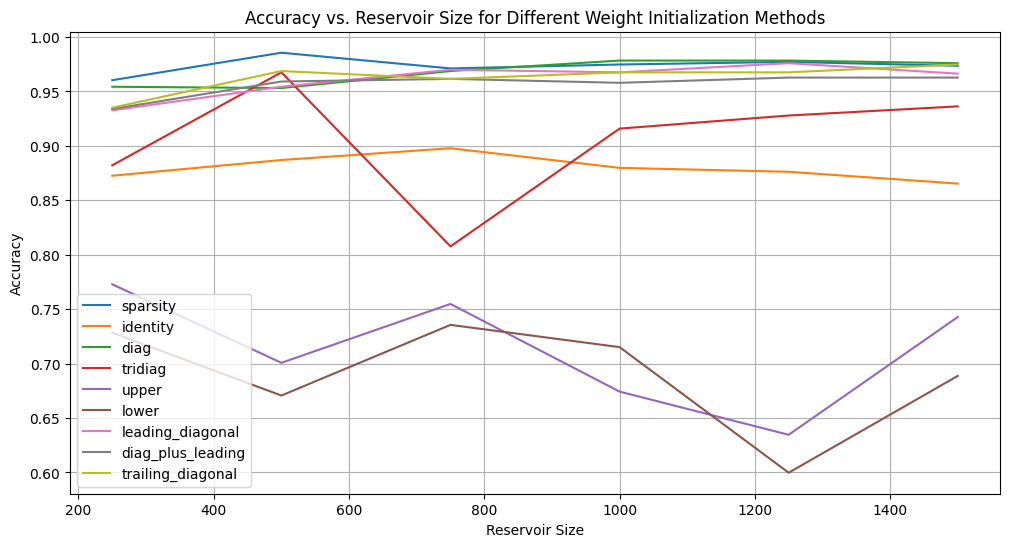

In [ ]:
# Create a dictionary to store accuracy results for each reservoir size and weight initialization method
accuracy_results = {}
reservoir_sizes = [250, 500, 750, 1000, 1250, 1500]
# Loop through your results and calculate accuracy values
for weight_init_method in weight_init_methods:
    for res_size in reservoir_sizes:
        esn = EchoStateNetworkImproved(reservoir_size=res_size, spectral_radius=0.9, connectivity=0.1, input_scaling=0.2)
        esn.fit(X_train, y_train, weight_init=weight_init_method)

        y_pred_classes = esn.predict_classes(X_test, threshold=0.5)

        # Calculate accuracy and store it in the dictionary
        accuracy = accuracy_score(y_test, y_pred_classes)
        accuracy_results[(res_size, weight_init_method)] = accuracy

# Create a plot for each weight initialization method
plt.figure(figsize=(12, 6))

for method in weight_init_methods:
    accuracy_values = [accuracy_results[(size, method)] for size in reservoir_sizes]
    plt.plot(reservoir_sizes, accuracy_values, label=method)

plt.title('Accuracy vs. Reservoir Size for Different Weight Initialization Methods')
plt.xlabel('Reservoir Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

ANOVA test can help to find the whether there is a significant difference in the results or not

In [ ]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Extract accuracy values for each weight initialization method
method_accuracies = [results_df[results_df['Weight Init Method'] == method]['Accuracy'] for method in weight_init_methods]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*method_accuracies)

# Check if there are significant differences
if p_value < 0.05:  # You can adjust the significance level (alpha) as needed
    print("ANOVA: There are significant differences among weight initialization methods.")

    # Perform Tukey's HSD test for pairwise comparisons
    tukey = pairwise_tukeyhsd(endog=results_df['Accuracy'], groups=results_df['Weight Init Method'], alpha=0.05)

    # Print the summary of the Tukey's HSD test
    print(tukey.summary())
else:
    print("ANOVA: No significant differences among weight initialization methods.")

ANOVA: No significant differences among weight initialization methods.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4141: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(stats.DegenerateDataWarning(msg))


Following is the EchostateNetwork definition for MNIST

In [ ]:
# Define the Echo State Network (ESN) class
class EchoStateNetwork:
    def __init__(self, input_size, reservoir_size, spectral_radius, weight_init='random'):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.weight_init = weight_init

        # Initialize the reservoir weights
        if self.weight_init == 'sparsity':
            self.W = np.random.rand(self.reservoir_size, self.reservoir_size)
            self.W [self.W  > self.spectral_radius] = 0
        elif self.weight_init == 'identity':
            self.W = np.identity(self.reservoir_size)
        elif self.weight_init == 'diag':
            self.W = np.diag(np.random.rand(self.reservoir_size))
        elif self.weight_init == 'tridiag':
            upper_diag = np.random.rand(self.reservoir_size)
            self.W = np.diag(upper_diag) + np.diag(upper_diag[:-1], 1) + np.diag(upper_diag[:-1], -1)
        elif self.weight_init == 'leading_diagonal':
            lower_diag = np.random.rand(self.reservoir_size-1)
            self.W = np.diag(lower_diag, k=1)
        elif self.weight_init == 'diag_plus_leading':
            diag = np.random.rand(self.reservoir_size - 1)
            self.W = np.diag(np.random.rand(self.reservoir_size)) + np.diag(diag, k=1)
        elif self.weight_init == 'trailing_diagonal':
            diag = np.random.rand(self.reservoir_size - 1)
            self.W =  np.diag(diag, k=-1)
        elif self.weight_init== 'upper':
            self.W = np.triu(np.random.rand(self.reservoir_size, self.reservoir_size))
        elif self.weight_init == 'lower':
            self.W = np.tril(np.random.rand(self.reservoir_size, self.reservoir_size))



        # Scale the weights by spectral radius
        self.W *= self.spectral_radius / np.max(np.abs(np.linalg.eigvals(self.W)))

        # Initialize the input weights and bias
        self.W_in = np.random.rand(reservoir_size, input_size) - 0.5
        self.b = np.random.rand(reservoir_size, 1) - 0.5

    def _compute_reservoir_states(self, X):
        T = X.shape[0]
        X = X.T

        # Initialize the reservoir states
        X_reservoir = np.zeros((self.reservoir_size, T))

        # Compute the reservoir states
        for t in range(1, T):
            u = X[:, t].reshape(-1, 1)
            x_prev = X_reservoir[:, t-1].reshape(-1, 1)
            x = np.tanh(self.W_in @ u + self.W @ x_prev + self.b)
            X_reservoir[:, t] = x.flatten()

        return X_reservoir

    def train(self, X, y):
        # Compute the reservoir states
        X_reservoir = self._compute_reservoir_states(X)

        # Ridge regression training
        clf = LinearRegression()
        clf.fit(X_reservoir.T, y)
        threshold = 0.01  # Adjust the threshold value
        clf.coef_[np.abs(clf.coef_) < threshold] = 0
        self.clf = clf

    def predict(self, X):
        # Compute the reservoir states
        X_reservoir = self._compute_reservoir_states(X)

        # Perform predictions using the trained regressor
        y_pred = self.clf.predict(X_reservoir.T)

        return y_pred